In [9]:
import numpy as np
import pandas as pd
import torch
from permetrics import RegressionMetric

from experiment_runner import (
    ControlConfig,
    ProposedMethodConfig,
    run_comparison_experiments,
)
from svd_based_optimizer import SvdOptimizer
from ols_optimizer import OlsOptimizer
import matplotlib.pyplot as plt
from dimension_estimation import estimate_dimension, OptimalDimensionSelectionMethod, CaoEstimator
from lag_estimation import estimate_tau, OptimalLagSelectionMethod, AmiEstimator

## Loading the dataset

In [2]:
dataset = pd.read_csv(r".\data\SeriesReport-Seasonally Adjusted Sales - Monthly (Millions of Dollars).csv")
dataset.head()

,Period,Value
0,01-01-1992,164095.0
1,01-02-1992,164213.0
2,01-03-1992,163721.0
3,01-04-1992,164709.0
4,01-05-1992,165612.0


In [3]:
dataset.describe()

,Value
count,341.000000
mean,334938.158358
std,100739.123688
min,163721.000000
25%,249520.000000
50%,340517.000000
75%,414137.000000
max,529616.000000


In [4]:
time_series = dataset['Value'].values
time_series = time_series[np.nonzero(~np.isnan(time_series))]

In [5]:
time_series_mu = np.mean(time_series)
time_series_std = np.std(time_series)

time_series = (time_series - time_series_mu) / time_series_std
time_series = np.diff(time_series, prepend=time_series[0])

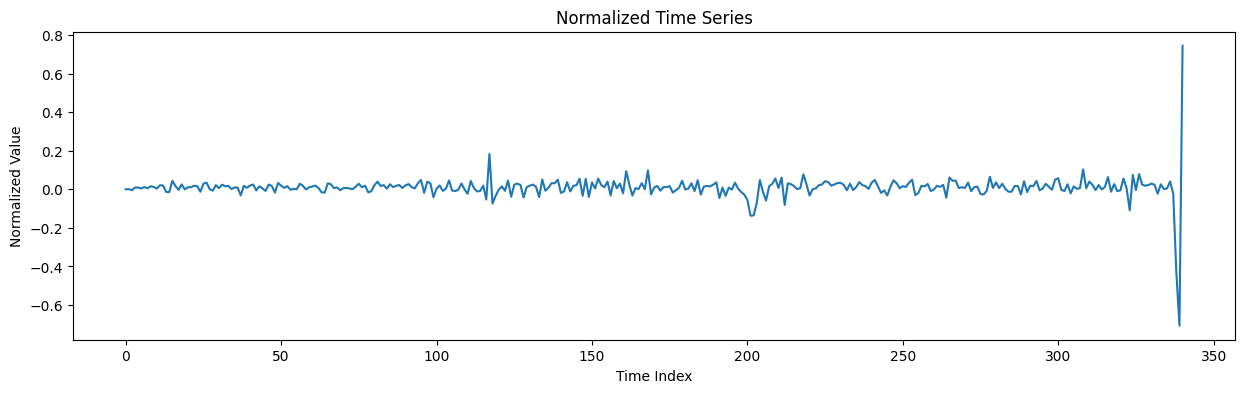

In [6]:
plt.figure(figsize=(15, 4))
plt.plot(time_series)
plt.title('Normalized Time Series')
plt.xlabel('Time Index')
plt.ylabel('Normalized Value')
plt.show()

## Estimating the embedding parameters

In [10]:
tau = estimate_tau(
    time_series,
    estimator=AmiEstimator(
        max_lag=20, optimum_selection_method=OptimalLagSelectionMethod.FIRST_LOC_MIN
    ),
)
print(f"Estimated tau: {tau}")

Estimated tau: 2


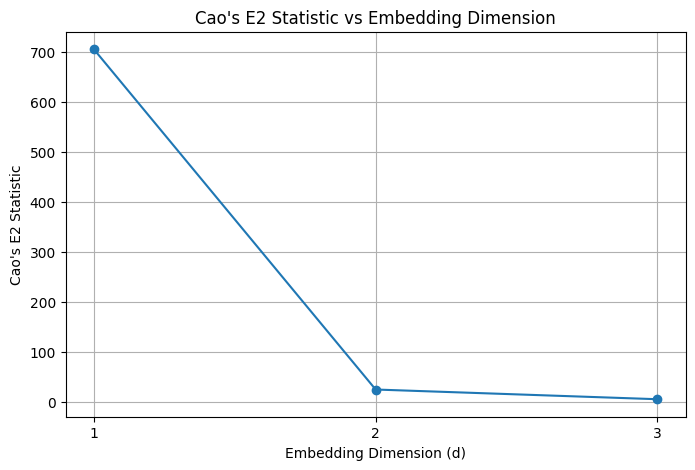

Estimated dimension: 3


In [16]:
dim = estimate_dimension(
    time_series,
    estimator=CaoEstimator(
        delay=tau,
        max_dim=3,
        optimum_selection_method=OptimalDimensionSelectionMethod.FIRST_LOC_MIN,
        plot=True,
    ),
)
print(f"Estimated dimension: {dim}")

## Configuring the models

In [17]:
configs = [
        *[
            ProposedMethodConfig(
                approach="no_pretraining",
                optimizer=SvdOptimizer(epsilon=0.05, alpha=alpha),
                m=m,
                post_tune=post_tune,
            )
            for m in [5, 10, 15, 20]
            # for m in [10, 20, 30, 50, 100, 200, 500, 1000]
            for alpha in [1e-2, 1e-1, 5e-1, 1, 5]
            for post_tune in [True, False]
        ],
        *[
            ProposedMethodConfig(
                approach="pretraining",
                optimizer=OlsOptimizer(rho=rho),
                m=100
            )
            for rho in [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
        ]
    ]

control_config = ControlConfig(m=10)

In [18]:
proposed_results, control_result = run_comparison_experiments(
        time_series,
        configs,
        control_config,
        train_ratio=0.75,
        device="cuda" if torch.cuda.is_available() else "cpu",
        run_parallel=False,
        show_progress=True,
    )

if not isinstance(proposed_results, list):
    proposed_results = [proposed_results]

ValueError: centres must be non-empty

In [ ]:
results_df = pd.DataFrame(
    {
        "Type": [],
        "Name": [],
        "Test R": [],
        "Test R^2": [],
        "Test NRMSE": [],
    }
)

for res in proposed_results:
    test_metrics = RegressionMetric(
        y_pred=res.test_predictions,
        y_true=res.test_targets,
    )

    new_row = pd.DataFrame(
        {
            "Type": ["Proposed"],
            "Name": [
                f"{res.method_name} (m={res.metadata['total_centers']}, alpha={res.metadata['optimizer_params']['_alpha']})" if res.metadata["optimizer_type"] == "SvdBasedOptimizer" else
                f"{res.method_name} (|C|={res.metadata['selected_centers']}, rho={res.metadata['optimizer_params']['_rho']})"
            ],
            "Test R": [test_metrics.pearson_correlation_coefficient()],
            "Test R^2": [test_metrics.R2()],
            "Test NRMSE": [test_metrics.normalized_root_mean_square_error()],
        }
    )
    results_df = pd.concat([results_df, new_row], ignore_index=True)

control_test_metrics = RegressionMetric(
    y_pred=control_result.test_predictions,
    y_true=control_result.test_targets,
)

new_row = pd.DataFrame(
    {
        "Type": ["Control"],
        "Name": ["Control (m=20)"],
        "Test R": [control_test_metrics.pearson_correlation_coefficient()],
        "Test R^2": [control_test_metrics.R2()],
        "Test NRMSE": [control_test_metrics.normalized_root_mean_square_error()],
    }
)
results_df = pd.concat([results_df, new_row], ignore_index=True)

In [ ]:
results_df.sort_values(by=["Type", "Test NRMSE"], ascending=[True, True]).head(10)

,Type,Name,Test R,Test R^2,Test NRMSE
40,Control,Control (m=20),-0.921484,-10.738390,4.176534
1,Proposed,"Proposed (m=5, alpha=0.01)",-0.842777,-5.164532,4.071313
20,Proposed,"Proposed (m=15, alpha=0.01)",-0.745244,-3.420962,4.289416
9,Proposed,"Proposed (m=5, alpha=5)",-0.674228,-3.282276,4.535786
38,Proposed,"Proposed (m=20, alpha=5)",-0.876324,-6.416202,4.722052
12,Proposed,"Proposed (m=10, alpha=0.1)",-0.897620,-7.404020,4.968587
29,Proposed,"Proposed (m=15, alpha=5)",-0.798746,-4.601262,5.016968
36,Proposed,"Proposed (m=20, alpha=1)",-0.838749,-6.200976,5.093294
34,Proposed,"Proposed (m=20, alpha=0.5)",-0.834642,-6.052177,5.158885
22,Proposed,"Proposed (m=15, alpha=0.1)",-0.795949,-5.324188,5.161605


In [ ]:
PROPOSED_MODEL_SELECTION_CRITERION_FOR_PLOTTING = "Test NRMSE"

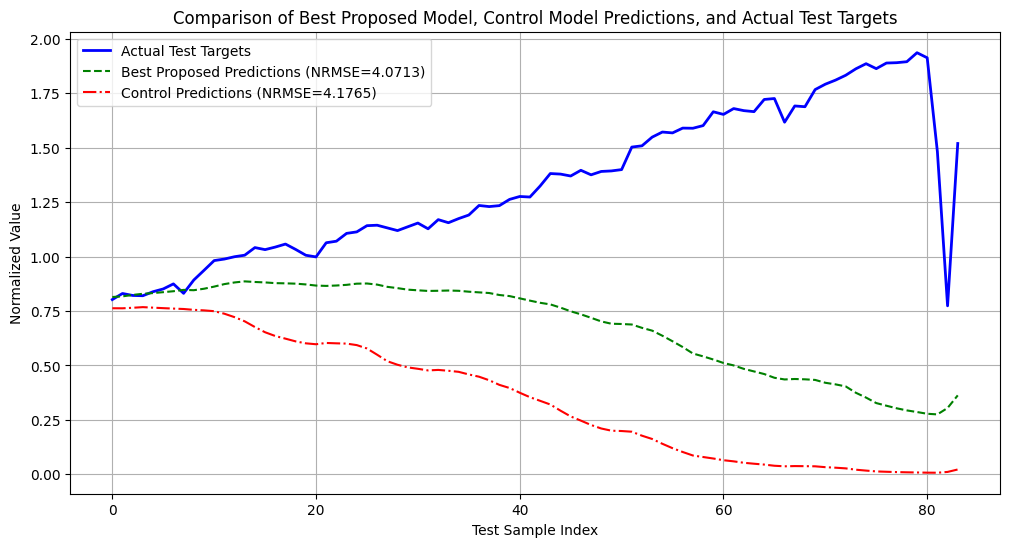

In [ ]:
# Find the index of the best proposed model based on lowest Test NRMSE
best_idx = results_df[results_df['Type'] == 'Proposed'][PROPOSED_MODEL_SELECTION_CRITERION_FOR_PLOTTING].idxmin()
best_res = proposed_results[best_idx]

# Get test targets (actual values for test set)
test_targets = best_res.test_targets  # Assuming all have the same test_targets

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_targets, label='Actual Test Targets', color='blue', linewidth=2)
plt.plot(best_res.test_predictions, label=f'Best Proposed Predictions (NRMSE={results_df.loc[best_idx, "Test NRMSE"]:.4f})', color='green', linestyle='--')
plt.plot(control_result.test_predictions, label=f'Control Predictions (NRMSE={control_test_metrics.normalized_root_mean_square_error():.4f})', color='red', linestyle='-.')
plt.xlabel('Test Sample Index')
plt.ylabel('Normalized Value')
plt.title('Comparison of Best Proposed Model, Control Model Predictions, and Actual Test Targets')
plt.legend()
plt.grid(True)
plt.show()